This Notebook Provide basic EDA Kernel for the Severstal: Steel Defect Detection
The kernel analyzes images in some vision traditional ways

Do upvote if you liked my kernel :)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.listdir("../input/severstal-steel-defect-detection")


## Import Libraries 

In [ ]:
from matplotlib import pyplot as plt
from itertools import cycle, islice
from tqdm import tqdm, tqdm_notebook
import seaborn as sns; sns.set_style("white")
import random
import cv2
from PIL import Image

## Load Train.csv

In [ ]:
train_data = pd.read_csv("../input/severstal-steel-defect-detection/train.csv")
train_data.head()

## Clean Tarin.csv
The Train.csv need some cleanup :
1. We need to replace the NaN values in EncodePixels Column
2. We need to correct the files names - instead of xxxxxxid.jpg_y ---> xxxxxxid.jpg
3. We need to add a column of classid 

In [ ]:
train_data['EncodedPixels'].fillna(-1, inplace=True)
train_data['ClassId'] = train_data['ImageId_ClassId'].apply(lambda x: int(x[-1:]))
train_data['ImageName'] = train_data['ImageId_ClassId'].apply(lambda x: x[:-6] +  '.jpg' )
train_data['Defect'] =np.where(train_data['EncodedPixels']==-1, 0, 1) 
train_data['ClassId'] =np.where(train_data['EncodedPixels']==-1,  0,train_data['ClassId']) 
train_data.head()

## Number of Images Per Class

In [ ]:
colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(train_data)))
DF_Defect = train_data[train_data['EncodedPixels']!=-1]
ax = DF_Defect['ClassId'].value_counts().plot(kind='bar',
                                    figsize=(14,8),color=colors)
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")
plt.xticks(rotation=360)
plt.show()

## Number of Classes per Image

In [ ]:
train_data.groupby(['ImageName'])['Defect'].sum().hist()

In [ ]:
path_img_train = "../input/severstal-steel-defect-detection/train_images/"
path_img_test = "../input/severstal-steel-defect-detection/test_images/"

## Data Exploratory 

## Images with Histogram 

While browsing randomly on images from both train and test set, there are few obvious conclusion 
1. A lot of the pictures have a large black area 
2. There is a portion of images with saturation or overexposed area 


Since these images are more don't contain colors, in all of the explorations I am using gray photos, it is easier to analyze
So one traditional way to explore images is pixes histogram 

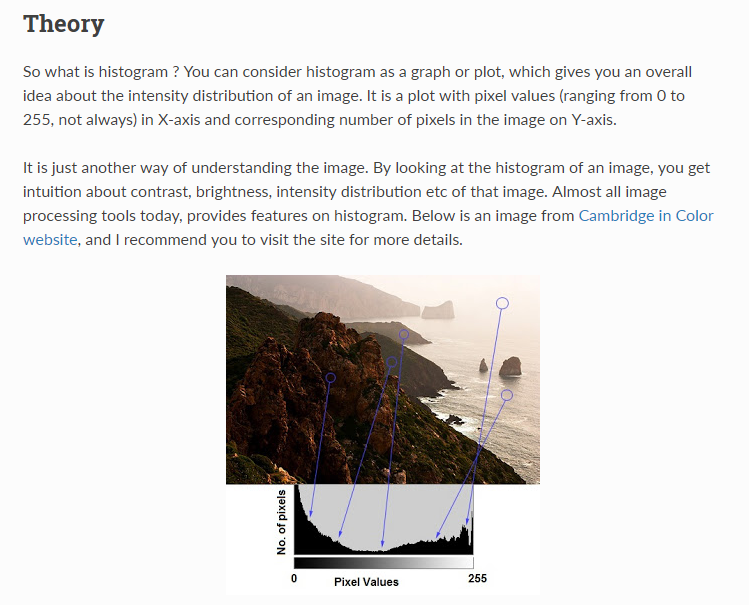
This image is taken from OpenCv Python Tutorial  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html

Pixel Values close to zero are Blacks, While high values pixels (256) are usually overexposed or saturated.
In both cases, extremes values mean that there are no details in the image

Let's explore some examples. 

In [ ]:
#This function show a gride of images, and their histogram 

def show_images_with_Histograms(images, cols = 2, titles = None):
   
    n_images = len(images)
    nrows = int(n_images/cols)
    fig, ax = plt.subplots(nrows, 2*  cols )
    
    assert((titles is None)or (len(images) == len(titles)))
    
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    
    row = 0
    col = 0 
    for n, (image, title) in enumerate(zip(images, titles)):
        
        if image.ndim == 2:
            plt.gray()
        ax[row,col].imshow(image)
        ax[row,col].set_title(title,fontsize=42)
        
        col +=1 
        if col == 2 * cols : 
            col =0
            row +=1
        
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        ax[row,col].hist(img_gray.ravel(),30,[0,256])
       
        col +=1 
        if col == 2 * cols : 
            col =0
            row +=1
            
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images   )
    fig.subplots_adjust(hspace = 0.8)
    #plt.show()

First let's see Random  train images 

In [ ]:
SEED = 87
imgs = []
titles = []
plt.rcParams.update({'font.size': 36})
for i in range(10):
    #plt.figure(figsize=(5,5))
    random.seed(SEED + i)
    id = random.choice(os.listdir(path_img_train))
    id_code = id.split(".")[0]
    imgs.append(np.asarray(Image.open(os.path.join(path_img_train, id))))
    
    titles.append("Image:"+str(id))
show_images_with_Histograms(imgs, cols = 1,titles = titles)
    #imgplot = plt.imshow(imgs[i])
    #plt.show()

 Now Let's see Random test images

In [ ]:
SEED = 34
imgs = []
titles = []
 
for i in range(10):
    #plt.figure(figsize=(5,5))
    random.seed(SEED + i)
    id = random.choice(os.listdir(path_img_test))
    id_code = id.split(".")[0]
    imgs.append(np.asarray(Image.open(os.path.join(path_img_test, id))))
    
    titles.append("Image:"+str(id))
show_images_with_Histograms(imgs, cols = 1,titles = titles)
    #imgplot = plt.imshow(imgs[i])
    #plt.show()

Let's see  some images with defects.  

In [ ]:
SEED = 12
imgs = []
titles = []
DF_Defect_only = train_data[train_data['Defect']!= 0]

for i in range(10):
    
    
    DF = DF_Defect_only.sample(n = 1, replace = False , random_state = SEED + i) 
    id = DF['ImageName'].values[0]
    label = DF['ClassId'].values[0]
    imgs.append(np.asarray(Image.open(os.path.join(path_img_train, id))))
    
    titles.append("Image:"+str(id)+" Class is:"+str(label))
show_images_with_Histograms(imgs, cols = 1,titles = titles)
    #imgplot = plt.imshow(imgs[i])
    #plt.show()

## Calculate the Active area
Calculate the Active area of the image

Calculate the percentage of the area that the non-black areas  occupy  from the entire image area

In [ ]:
#Calculate the Active area of the image 

def Calc_Active_Area(img):
    Thrshold = 10 
    ImageSize = img.shape[0] * img.shape[1]
    Black_size = np.count_nonzero(img < Thrshold )
   
    
    active_area = ((ImageSize - Black_size)/ImageSize)*100
    
    
    return int(active_area)

In [ ]:
SEED = 12
imgs = []
titles = []
DF_Defect_only = train_data[train_data['Defect']!= 0]
plt.rcParams.update({'font.size': 45})
for i in range(10):
    
    
    DF = DF_Defect_only.sample(n = 1, replace = False , random_state = SEED + i) 
    id = DF['ImageName'].values[0]
    label = DF['ClassId'].values[0]
    Active_area = Calc_Active_Area(np.asarray(Image.open(os.path.join(path_img_train, id)).convert('L')))
    imgs.append(np.asarray(Image.open(os.path.join(path_img_train, id))))
    
    titles.append("Image:"+str(id)+"  Active Area  is:"+str(Active_area)+'%')
show_images_with_Histograms(imgs, cols = 1,titles = titles)
    #imgplot

Another problem is saturation - large areas which areas   overexposed 

## Calculate Saturated area 
This function calculates the percentage o pixels which are overexposed or saturated

In [ ]:
#Calculate the Saturated area of the image 

def Calc_Saturate_Area(img):
    Thrshold = 240 
    ImageSize = img.shape[0] * img.shape[1]
    saturate_area = np.count_nonzero(img > Thrshold )
   
    
    saturate_area = ((saturate_area)/ImageSize)*100
    
    
    return int(saturate_area)

Let's see train images 

In [ ]:
SEED = 44
imgs = []
titles = []
DF_Defect_only = train_data[train_data['Defect']!= 0]
plt.rcParams.update({'font.size': 42})
for i in range(10):
    
    
    DF = train_data.sample(n = 1, replace = False , random_state = SEED + i) 
    id = DF['ImageName'].values[0]
   
    Saturate_Area = Calc_Saturate_Area(np.asarray(Image.open(os.path.join(path_img_train, id)).convert('L')))
    imgs.append(np.asarray(Image.open(os.path.join(path_img_train, id))))
    
    titles.append("Image:"+str(id)+" Saturated Area  is:"+str(Saturate_Area)+'%')
show_images_with_Histograms(imgs, cols = 1,titles = titles)

In the last stage - I will add two columns to the train data frames to include 

the Active area percentage and the saturated area percentage 

In [ ]:
def Calculate_Active_area_from_file_name(FileName):
    img = np.asarray(Image.open(os.path.join(path_img_train, FileName)).convert('L'))
    result = Calc_Active_Area(img)
    return result 


def Calculate_Saturated_area_from_file_name(FileName):
    img = np.asarray(Image.open(os.path.join(path_img_train, FileName)).convert('L'))
    result = Calc_Saturate_Area(img)
    return result 

In [ ]:
DF = train_data.drop_duplicates(subset='ImageName')
DF['ActiveArea'] = DF['ImageName'].apply(lambda x:Calculate_Active_area_from_file_name(x))


DF['SaturatedArea'] = DF['ImageName'].apply(lambda x:Calculate_Saturated_area_from_file_name(x))
DF.head()

In [ ]:
DF['ActiveArea'].hist()

In [ ]:
DF['SaturatedArea'].hist()

In [ ]:
DF.head(100)

This data is only for the images themselves without the mask.

What we can do with this data ?

Maybe take it into account when we build our K folds (make sure there is a balance)

Downsample (usually towards the last epochs or at the end of the training) and try use images which have high active area and not saturated  

## Masks 

Thanks to 
https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

In [ ]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

## Sample Mask

In [ ]:
mask = (rle2mask(DF['EncodedPixels'][20]))
print(mask.shape)

id = DF['ImageName'].values[5]
img = np.asarray(Image.open(os.path.join(path_img_train, id)))

In [ ]:
plt.figure(figsize = (20,20)) 
plt.rcParams.update({'font.size': 15})
plt.imshow(mask)



In [ ]:
plt.figure(figsize = (20,20)) 
plt.imshow(img)